In [3]:
#Getting coordinates imports

from geopy.geocoders import Nominatim #Transform Adresses to Coordinates (EPSG:4326)
from osgeo.osr import SpatialReference, CoordinateTransformation #Changing coordinatesystem (EPSG:4326 to EPSG:31370)

#Opening and clipping tif imports

import rasterio #Handling tif files
import rioxarray #Handling Rasters

#Showing CHM

from rasterio.plot import show
import numpy as np

In [4]:
#Using Geopy to enter a random adress and convert into EPSG:4326 coordinates

#Input Adress by user
adress = input("Please enter your adress (f.e.: Beliestraat 137 2910 Essen) here: ")

#Getting the coordinates in EPSG:4326 system (standard)
geolocator = Nominatim(user_agent = "coordinate_finder")
location = geolocator.geocode(adress)

Please enter your adress (f.e.: Beliestraat 137 2910 Essen) here: Beliestraat 137 2910 Essen


In [5]:
#Changing coordinatesystem from 4326 to EPSG:31370

#Importing EPSG:4326 system
epsg4326 = SpatialReference() 
epsg4326.ImportFromEPSG(4326)

#Importing EPSG:4326 system
epsg31370 = SpatialReference()
epsg31370.ImportFromEPSG(31370)

#Make a transform function to change coordinates from a EPSG:4326 to a EPSG:31370 system
transform = CoordinateTransformation(epsg4326, epsg31370)

#Run transform function on Address coordinates 
(adress_lat, adress_long, _) = transform.TransformPoint(location.latitude, location.longitude)

In [5]:
#Checking in which DSM/DTM tif file these coordinates are located

////////////////
NOG IN TE VULLEN
////////////////

156488.49577211653 239213.01287099905


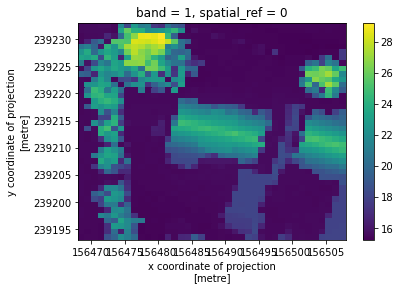

In [6]:
#Clipping of DSM tif

#Opening the DSM tif

DSM = rioxarray.open_rasterio("DHMVIIDSMRAS1m_k01.tif",
                                   masked=True,chunks=True)

#Choosing Boundary of the clip (in EPSG:31370 coordinates)
#on each side of the Adress coordinates

boundary = 20

#Left upper corner
xmin_ymax = [(adress_lat-boundary),(adress_long+boundary)]

#Right upper corner
xmax_ymax = [(adress_lat+boundary),(adress_long+boundary)]

#Left lower corner
xmax_ymin = [(adress_lat+boundary),(adress_long-boundary)]

#Right lower corner
xmin_ymin = [(adress_lat-boundary),(adress_long-boundary)]

#Making a polygon based on the boundaries around the Adress coordinates

clip_boundaries = [ {'type': 'Polygon',
                'coordinates': [[xmin_ymax,
                                 xmax_ymax,
                                 xmax_ymin,
                                 xmin_ymin ]]}]

#Actual clipping of the polygon from the DSM tif
   
clipped_DSM = DSM.rio.clip(clip_boundaries)

#Plotting the clipped DSM tif

clipped_DSM.plot()

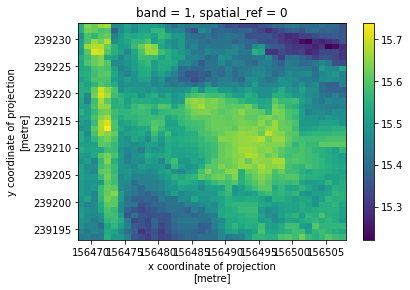

In [7]:
#Clipping of DTM tif

#Opening the DTM tif

DTM = rioxarray.open_rasterio("DHMVIIDTMRAS1m_k01.tif",
                                   masked=True,chunks=True)

#Choosing Boundary of the clip (in EPSG:31370 coordinates)
#on each side of the Adress coordinates

boundary = 20

#Left upper corner
xmin_ymax = [(adress_lat-boundary),(adress_long+boundary)]

#Right upper corner
xmax_ymax = [(adress_lat+boundary),(adress_long+boundary)]

#Left lower corner
xmax_ymin = [(adress_lat+boundary),(adress_long-boundary)]

#Right lower corner
xmin_ymin = [(adress_lat-boundary),(adress_long-boundary)]

#Making a polygon based on the boundaries around the Adress coordinates

clip_boundaries = [ {'type': 'Polygon',
                'coordinates': [[xmin_ymax,
                                 xmax_ymax,
                                 xmax_ymin,
                                 xmin_ymin ]]}]

#Actual clipping of the polygon from the DTM tif
   
clipped_DTM = DTM.rio.clip(clip_boundaries)

#Plotting the clipped DTM tif

clipped_DTM.plot()

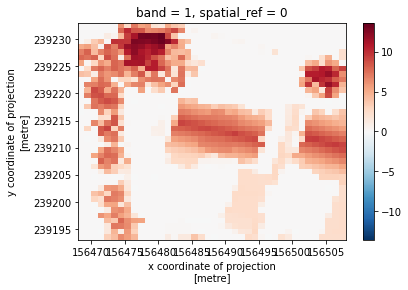

In [8]:
#Creating a Canopy Height Model of the clipped DSM and DTM

clipped_CHM = clipped_DSM - clipped_DTM 
clipped_CHM.compute()

clipped_CHM.plot()

In [ ]:
#next steps:

1. get the shp files of the building:
    
https://docs.basisregisters.vlaanderen.be/docs/api-documentation.html#tag/Adressen
    
input adres 
--> get objectid for gebouweenheid 
--> get the object id for gebouw with it 
--> get the polygon with the gebouw id

2. 3D mathplotlib plot